IMPORT MODULES

In [23]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D , MaxPooling2D , Flatten, Dense,Dropout,BatchNormalization
from PIL import Image,ImageOps,ImageEnhance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, plot_model
from sklearn.utils import class_weight
import os

AUGMENTATION

In [24]:
def rotate(img,angle):
    return img.rotate(angle=angle)

def flip(img):
    return ImageOps.mirror(img)

def change_brightness(img,factor = 1.2):
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(factor)

IMPORT  DATASET

In [25]:
le = LabelEncoder()

In [26]:
le.fit(['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised'])

data = []
result = []

for emotion in ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']:
    class_index = le.transform([emotion])[0]
    class_label = to_categorical(class_index, num_classes=7)

    paths = []
    for r, d, f in os.walk(os.path.join(r"C:\Users\USER\Desktop\dataset\train", emotion)):
        for file in f:
            if file.lower().endswith((".jpg", "jpeg", ".png")):
                paths.append(os.path.join(r, file))

    for path in paths:
        pil_img = Image.open(path).convert('L').resize((48, 48))

        arr_img = np.expand_dims(np.array(pil_img).astype('float32') / 255.0, -1)
        if arr_img.shape == (48, 48, 1):
            data.append(arr_img)
            result.append(class_label)

        if emotion in ['disgusted', 'surprised']:
            flipped = ImageOps.mirror(pil_img)
            flipped_arr = np.expand_dims(np.array(flipped).astype('float32') / 255.0, -1)
            data.append(flipped_arr)
            result.append(class_label)

            rotated = pil_img.rotate(15)
            rotated_arr = np.expand_dims(np.array(rotated).astype('float32') / 255.0, -1)
            data.append(rotated_arr)
            result.append(class_label)

data = np.array(data)
result = np.array(result)


print("Final data shape:", data.shape)
print("Final result shape:", result.shape)

y_ints = np.argmax(result, axis=1)
print("Class counts after augmentation:", Counter(y_ints))

Final data shape: (35923, 48, 48, 1)
Final result shape: (35923, 7)
Class counts after augmentation: Counter({np.int64(6): 9513, np.int64(3): 7215, np.int64(4): 4965, np.int64(5): 4830, np.int64(2): 4097, np.int64(0): 3995, np.int64(1): 1308})


reshape the result to 2D(Already in 2D here)

In [27]:
result = result.reshape(-1,7)
result.shape

(35923, 7)

EXAMPLE OF DATA

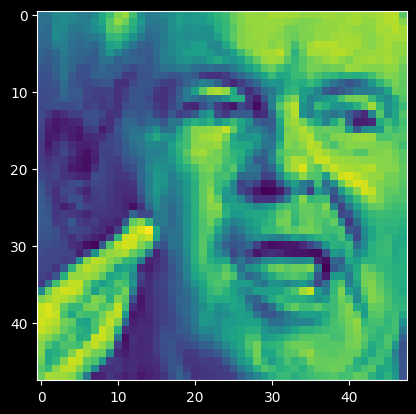

In [28]:
plt.imshow(data[6])

ADD WEIGHTS

In [29]:
y_ints = np.argmax(result, axis=1) 
y_ints

array([0, 0, 0, ..., 6, 6, 6])

In [30]:
from collections import Counter

class_counts = Counter(y_ints)
print("Class counts (by index):")
print(class_counts)

Class counts (by index):
Counter({np.int64(6): 9513, np.int64(3): 7215, np.int64(4): 4965, np.int64(5): 4830, np.int64(2): 4097, np.int64(0): 3995, np.int64(1): 1308})


In [31]:
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_ints),
    y=y_ints
)
class_weights = dict(enumerate(weights))
print("Class weights (by index):")
print(class_weights)

Class weights (by index):
{0: np.float64(1.2845699982120509), 1: np.float64(3.9234381826124944), 2: np.float64(1.2525890024059416), 3: np.float64(0.7112761112761112), 4: np.float64(1.0336066752985182), 5: np.float64(1.0624963028689738), 6: np.float64(0.5394572840173597)}


TRAIN-TEST SPLIT

In [32]:
xtrain, xtest, ytrain, ytest = train_test_split(data, result, test_size=0.2, random_state=42,shuffle=True)

MODEL DESIGN

In [43]:
from tensorflow.keras import layers, regularizers

model = Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularizers.l2(5e-5),
                        input_shape=(48, 48, 1)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())

model.add(layers.Conv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularizers.l2(5e-5)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())

model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.15))



model.add(layers.Conv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularizers.l2(5e-5)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())

model.add(layers.Conv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularizers.l2(5e-5)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())

model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))


model.add(layers.Conv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularizers.l2(5e-5)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())

model.add(layers.Conv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularizers.l2(5e-5)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())

model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.35))


model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.50))
model.add(layers.Dense(7, activation='softmax'))


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 12, 12, 128)    │             

 Total params: 305,639 (1.17 MB)

 Trainable params: 304,743 (1.16 MB)

 Non-trainable params: 896 (3.50 KB)

COMPILE

In [45]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss=loss_fn,
    metrics=['accuracy']
)

ADDING CALLBACKS

In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',  
    monitor='val_loss',         
    save_best_only=True,        
    verbose=1
)


In [37]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience = 7,                
    restore_best_weights=True,
    verbose=1
)


In [38]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    verbose=1,
    min_lr=1e-6
)

TRAIN

In [48]:
model.fit(
    xtrain, ytrain,
    validation_data=(xtest, ytest),
    epochs=40,
    batch_size=64,
    class_weight = class_weights,
    callbacks=[checkpoint, early_stop, reduce_lr],
    shuffle=True
)

Epoch 1/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.2350 - loss: 1.9388
Epoch 1: val_loss improved from inf to 2.21605, saving model to best_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 142s 315ms/step - accuracy: 0.2351 - loss: 1.9386 - val_accuracy: 0.2099 - val_loss: 2.2161 - learning_rate: 5.0000e-04
Epoch 2/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.3439 - loss: 1.7851
Epoch 2: val_loss improved from 2.21605 to 1.69379, saving model to best_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 144s 320ms/step - accuracy: 0.3441 - loss: 1.7850 - val_accuracy: 0.3918 - val_loss: 1.6938 - learning_rate: 5.0000e-04
Epoch 3/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.4222 - loss: 1.6894
Epoch 3: val_loss did not improve from 1.69379
450/450 ━━━━━━━━━━━━━━━━━━━━ 144s 320ms/step - accuracy: 0.4223 - loss: 1.6893 - val_accuracy: 0.3402 - val_loss: 1.7606 - learning_rate: 5.0000e-04
Epoch 4/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.4719 - loss: 1.6046
Epoch 4: val_loss did not improve from 1.69379
450/450 ━━━━━━━━━━━━━━━━━━━━ 143s 319ms/step - accuracy: 0.4719 - loss: 1.6045 - val_accuracy: 0.3278 - val_loss: 1.8148 - learning_rate: 5.0000e-04
Epoch 5/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.4906 - loss: 1.5591
Epoch 5: val_loss improved from 1.69379 to 1.49916, saving model to best_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 146s 324ms/step - accuracy: 0.4907 - loss: 1.5591 - val_accuracy: 0.4988 - val_loss: 1.4992 - learning_rate: 5.0000e-04
Epoch 6/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.5135 - loss: 1.5231
Epoch 6: val_loss did not improve from 1.49916
450/450 ━━━━━━━━━━━━━━━━━━━━ 144s 319ms/step - accuracy: 0.5136 - loss: 1.5231 - val_accuracy: 0.3471 - val_loss: 1.8322 - learning_rate: 5.0000e-04
Epoch 7/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.5414 - loss: 1.4659
Epoch 7: val_loss did not improve from 1.49916
450/450 ━━━━━━━━━━━━━━━━━━━━ 144s 321ms/step - accuracy: 0.5415 - loss: 1.4659 - val_accuracy: 0.3787 - val_loss: 1.7367 - learning_rate: 5.0000e-04
Epoch 8/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.5467 - loss: 1.4426
Epoch 8: val_loss improved from 1.49916 to 1.42873, saving model to best_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 144s 320ms/step - accuracy: 0.5468 - loss: 1.4426 - val_accuracy: 0.5247 - val_loss: 1.4287 - learning_rate: 5.0000e-04
Epoch 9/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.5702 - loss: 1.4099
Epoch 9: val_loss improved from 1.42873 to 1.41225, saving model to best_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 146s 324ms/step - accuracy: 0.5702 - loss: 1.4099 - val_accuracy: 0.5477 - val_loss: 1.4122 - learning_rate: 5.0000e-04
Epoch 10/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.5766 - loss: 1.4041
Epoch 10: val_loss improved from 1.41225 to 1.33124, saving model to best_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 147s 326ms/step - accuracy: 0.5766 - loss: 1.4041 - val_accuracy: 0.5829 - val_loss: 1.3312 - learning_rate: 5.0000e-04
Epoch 11/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.5850 - loss: 1.3888
Epoch 11: val_loss did not improve from 1.33124
450/450 ━━━━━━━━━━━━━━━━━━━━ 145s 322ms/step - accuracy: 0.5850 - loss: 1.3887 - val_accuracy: 0.4956 - val_loss: 1.5393 - learning_rate: 5.0000e-04
Epoch 12/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.5967 - loss: 1.3656
Epoch 12: val_loss improved from 1.33124 to 1.27979, saving model to best_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 144s 320ms/step - accuracy: 0.5967 - loss: 1.3656 - val_accuracy: 0.6136 - val_loss: 1.2798 - learning_rate: 5.0000e-04
Epoch 13/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.6033 - loss: 1.3400
Epoch 13: val_loss did not improve from 1.27979
450/450 ━━━━━━━━━━━━━━━━━━━━ 144s 320ms/step - accuracy: 0.6033 - loss: 1.3400 - val_accuracy: 0.4341 - val_loss: 1.6409 - learning_rate: 5.0000e-04
Epoch 14/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.6140 - loss: 1.3206
Epoch 14: val_loss did not improve from 1.27979
450/450 ━━━━━━━━━━━━━━━━━━━━ 144s 320ms/step - accuracy: 0.6140 - loss: 1.3207 - val_accuracy: 0.5908 - val_loss: 1.3134 - learning_rate: 5.0000e-04
Epoch 15/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.6129 - loss: 1.3144
Epoch 15: val_loss improved from 1.27979 to 1.26814, saving model to best_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 144s 320ms/step - accuracy: 0.6129 - loss: 1.3144 - val_accuracy: 0.6199 - val_loss: 1.2681 - learning_rate: 5.0000e-04
Epoch 16/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.6217 - loss: 1.2986
Epoch 16: val_loss did not improve from 1.26814
450/450 ━━━━━━━━━━━━━━━━━━━━ 143s 318ms/step - accuracy: 0.6217 - loss: 1.2986 - val_accuracy: 0.5709 - val_loss: 1.3608 - learning_rate: 5.0000e-04
Epoch 17/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.6257 - loss: 1.3037
Epoch 17: val_loss did not improve from 1.26814
450/450 ━━━━━━━━━━━━━━━━━━━━ 147s 327ms/step - accuracy: 0.6257 - loss: 1.3037 - val_accuracy: 0.5878 - val_loss: 1.3218 - learning_rate: 5.0000e-04
Epoch 18/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.6343 - loss: 1.2761
Epoch 18: val_loss did not improve from 1.26814
450/450 ━━━━━━━━━━━━━━━━━━━━ 144s 321ms/step - accuracy: 0.6343 - loss: 1.2761 - val_accuracy: 0.5486 - val_loss: 1.4509 - learning_rate: 5.00

450/450 ━━━━━━━━━━━━━━━━━━━━ 147s 327ms/step - accuracy: 0.6562 - loss: 1.2377 - val_accuracy: 0.6289 - val_loss: 1.2604 - learning_rate: 2.5000e-04
Epoch 21/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.6685 - loss: 1.2150
Epoch 21: val_loss improved from 1.26043 to 1.24030, saving model to best_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 145s 323ms/step - accuracy: 0.6685 - loss: 1.2150 - val_accuracy: 0.6344 - val_loss: 1.2403 - learning_rate: 2.5000e-04
Epoch 22/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.6757 - loss: 1.2037
Epoch 22: val_loss did not improve from 1.24030
450/450 ━━━━━━━━━━━━━━━━━━━━ 146s 324ms/step - accuracy: 0.6757 - loss: 1.2037 - val_accuracy: 0.6305 - val_loss: 1.2543 - learning_rate: 2.5000e-04
Epoch 23/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.6683 - loss: 1.2064
Epoch 23: val_loss improved from 1.24030 to 1.23500, saving model to best_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 147s 328ms/step - accuracy: 0.6684 - loss: 1.2064 - val_accuracy: 0.6462 - val_loss: 1.2350 - learning_rate: 2.5000e-04
Epoch 24/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.6754 - loss: 1.1929
Epoch 24: val_loss improved from 1.23500 to 1.21601, saving model to best_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 147s 327ms/step - accuracy: 0.6754 - loss: 1.1929 - val_accuracy: 0.6519 - val_loss: 1.2160 - learning_rate: 2.5000e-04
Epoch 25/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6846 - loss: 1.1808
Epoch 25: val_loss improved from 1.21601 to 1.17303, saving model to best_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 164s 364ms/step - accuracy: 0.6846 - loss: 1.1808 - val_accuracy: 0.6735 - val_loss: 1.1730 - learning_rate: 2.5000e-04
Epoch 26/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.6821 - loss: 1.1700
Epoch 26: val_loss did not improve from 1.17303
450/450 ━━━━━━━━━━━━━━━━━━━━ 192s 427ms/step - accuracy: 0.6821 - loss: 1.1700 - val_accuracy: 0.6540 - val_loss: 1.2326 - learning_rate: 2.5000e-04
Epoch 27/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.6904 - loss: 1.1723
Epoch 27: val_loss did not improve from 1.17303
450/450 ━━━━━━━━━━━━━━━━━━━━ 347s 772ms/step - accuracy: 0.6904 - loss: 1.1723 - val_accuracy: 0.6593 - val_loss: 1.2017 - learning_rate: 2.5000e-04
Epoch 28/40
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.6848 - loss: 1.1702
Epoch 28: val_loss did not improve from 1.17303
450/450 ━━━━━━━━━━━━━━━━━━━━ 140s 310ms/step - accuracy: 0.6848 - loss: 1.1702 - val_accuracy: 0.6757 - val_loss: 1.1887 - learning_rate: 2.50

In [50]:
test_loss, test_acc = model.evaluate(xtest, ytest)

print('Test Accuracy: ', test_acc)

225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.6473 - loss: 1.2116
Test Accuracy:  0.64913010597229


In [54]:
from matplotlib.pyplot import imshow
def names(num):
    return le.inverse_transform([num])[0]

img = Image.open(r"C:\Users\USER\Desktop\dataset\test\surprised\im0.png").convert('L')
x = img.resize((48,48))
x = np.array(x)
x = x.reshape(1,48,48,1)
predict = model.predict_on_batch(x)
classification = np.where(predict == np.max(predict))[1][0]
print(str(predict[0][classification]*100) + "% Confidence is this - " + names(classification))



100.0% Confidence is this - surprised


In [55]:
model.save('model_v1.h5')

In [56]:
from tensorflow.keras.models import load_model

model = load_model('best_model.h5')

In [57]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

In [58]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('best_model_finetuned.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)


In [59]:
history_fine = model.fit(
    xtrain, ytrain,
    validation_data=(xtest, ytest),
    epochs=10,
    batch_size=32,
    callbacks=[checkpoint, early_stop, reduce_lr],
    shuffle=True
)


Epoch 1/10
898/899 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6974 - loss: 1.1522

899/899 ━━━━━━━━━━━━━━━━━━━━ 138s 150ms/step - accuracy: 0.6974 - loss: 1.1522 - val_accuracy: 0.6809 - val_loss: 1.1641 - learning_rate: 5.0000e-05
Epoch 2/10
898/899 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7019 - loss: 1.1386

899/899 ━━━━━━━━━━━━━━━━━━━━ 143s 159ms/step - accuracy: 0.7019 - loss: 1.1386 - val_accuracy: 0.6807 - val_loss: 1.1624 - learning_rate: 5.0000e-05
Epoch 3/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 144s 160ms/step - accuracy: 0.7086 - loss: 1.1352 - val_accuracy: 0.6775 - val_loss: 1.1790 - learning_rate: 5.0000e-05
Epoch 4/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 145s 162ms/step - accuracy: 0.7040 - loss: 1.1330 - val_accuracy: 0.6637 - val_loss: 1.2074 - learning_rate: 5.0000e-05
Epoch 5/10
898/899 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.7091 - loss: 1.1283

899/899 ━━━━━━━━━━━━━━━━━━━━ 144s 161ms/step - accuracy: 0.7091 - loss: 1.1283 - val_accuracy: 0.6856 - val_loss: 1.1521 - learning_rate: 5.0000e-05
Epoch 6/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 144s 160ms/step - accuracy: 0.7149 - loss: 1.1140 - val_accuracy: 0.6746 - val_loss: 1.1728 - learning_rate: 5.0000e-05
Epoch 7/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 143s 159ms/step - accuracy: 0.7151 - loss: 1.1171 - val_accuracy: 0.6732 - val_loss: 1.1736 - learning_rate: 5.0000e-05
Epoch 8/10
898/899 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7157 - loss: 1.1137
Epoch 8: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
899/899 ━━━━━━━━━━━━━━━━━━━━ 143s 159ms/step - accuracy: 0.7157 - loss: 1.1137 - val_accuracy: 0.6800 - val_loss: 1.1605 - learning_rate: 5.0000e-05
Epoch 9/10
898/899 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7155 - loss: 1.1115

899/899 ━━━━━━━━━━━━━━━━━━━━ 144s 160ms/step - accuracy: 0.7155 - loss: 1.1115 - val_accuracy: 0.6894 - val_loss: 1.1470 - learning_rate: 2.5000e-05
Epoch 10/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 143s 159ms/step - accuracy: 0.7170 - loss: 1.1054 - val_accuracy: 0.6845 - val_loss: 1.1529 - learning_rate: 2.5000e-05


In [60]:
test_loss, test_acc = model.evaluate(xtest, ytest)

print('Test Accuracy: ', test_acc)

225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6900 - loss: 1.1488
Test Accuracy:  0.689352810382843
